# Assignment 3
### Armin Danesh Pazho | 801200833 | adaneshp@uncc.edu

## YOLOv5
_________________________________________
First we need to install all the dependencies. We can use the following commands for that:

In [59]:
!git clone https://github.com/ultralytics/yolov5.git

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [60]:
%cd yolov5/
!pip3 install -r requirements.txt

/home/armin/Documents/AAI/Assignment_3/yolov5
Defaulting to user installation because normal site-packages is not writeable


In [82]:
# Train YOLOv5s on COCO128 for 3 epochs
!python3 train.py --img 640 --batch 16 --epochs 20 --data signs.yaml --weights yolov5l.pt

1.11.0+cu113
train: weights=yolov5l.pt, cfg=, data=signs.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-187-g5ef69ef Python-3.10.6 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3090, 24259MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.

In [10]:
!python3 yolov5/detect.py --source 0 --weights '/home/armin/Documents/AAI/Assignment_3/yolov5/runs/train/exp10/weights/best.pt'

detect: weights=['/home/armin/Documents/AAI/Assignment_3/yolov5/runs/train/exp10/weights/best.pt'], source=0, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v6.2-187-g5ef69ef Python-3.10.6 torch-1.11.0+cu113 CUDA:0 (NVIDIA GeForce RTX 3090, 24259MiB)

Fusing layers... 
Model summary: 267 layers, 46124433 parameters, 0 gradients, 107.7 GFLOPs
1/1: 0...  Success (inf frames 640x480 at 30.00 FPS)

0: 480x640 (no detections), 438.1ms
0: 480x640 (no detections), 10.1ms
0: 480x640 (no detections), 8.9ms
0: 480x640 (no detections), 7.9ms
0: 480x640 (no detections), 8.1ms
0: 480x640 (no detections), 8.4ms
0: 480x640 (no detection

# RCNN
--------------------------------------

In [36]:
%cd ../

/home/armin/Documents/AAI/Assignment_3


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

print(torch.__version__)

DIR_INPUT = '/home/armin/Documents/AAI/Assignment_3/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

1.11.0+cu113


In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

/tmp/ipykernel_5173/746031410.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_df['x'] = train_df['x'].astype(np.float)
/tmp/ipykernel_5173/746031410.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_df['y'] = train_df['y'].astype(np.float)
/tmp/ipykernel_5173/746031410.py:18: DeprecationWarning: `np.float` is a depreca

In [5]:
valid_df.shape, train_df.shape

((25006, 8), (122787, 8))

In [6]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [7]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [9]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [13]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


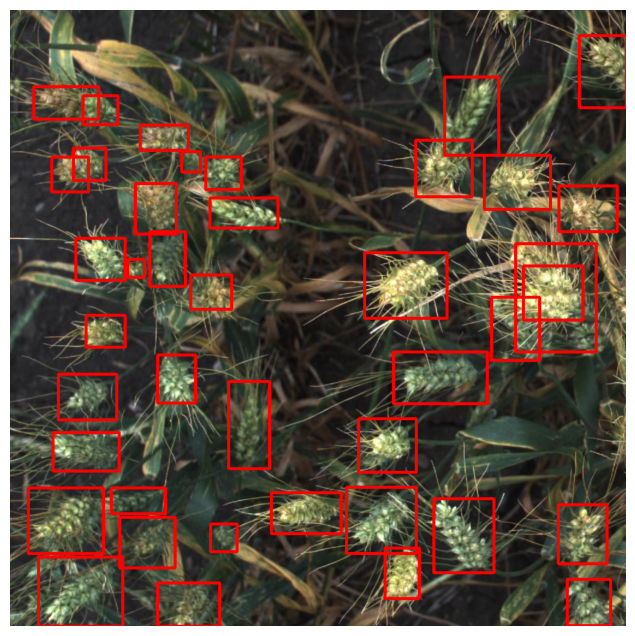

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [33]:
!python3 -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [34]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 5

loss_hist = Averager()
itr = 1
print(torch.__version__)
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   

1.11.0+cu113
Iteration #50 loss: 1.0844497129133528
Iteration #100 loss: 0.8381869384804936
Iteration #150 loss: 0.8295867312930435
Epoch #0 loss: 1.0420162066589878
Iteration #200 loss: 0.914713606540796
Iteration #250 loss: 0.8912429209228351
Iteration #300 loss: 0.7383034727317891
Epoch #1 loss: 0.8976421625756905
Iteration #350 loss: 0.8423001629684426
Iteration #400 loss: 0.9483575805695811
Iteration #450 loss: 0.6937341588499125
Iteration #500 loss: 0.8605531641067737
Epoch #2 loss: 0.8774518328410605
Iteration #550 loss: 0.8819913343391095
Iteration #600 loss: 1.1734140856617954
Iteration #650 loss: 0.9190726053442629
Epoch #3 loss: 0.8581963930864778
Iteration #700 loss: 0.9895790577154664
Iteration #750 loss: 0.9397021445511096
Iteration #800 loss: 0.7080194281751031
Iteration #850 loss: 0.7448415296018306
Epoch #4 loss: 0.8512412394139788


In [19]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [3]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load("/home/armin/Documents/AAI/Assignment_3/fasterrcnn_resnet50_fpn.pth"))
model.eval()

x = model.to(device)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
path = r'/home/armin/Documents/AAI/Assignment_3/global-wheat-detection/test/348a992bb.jpg'
img = cv2.imread(path, cv2.IMREAD_COLOR)

vid = cv2.VideoCapture(0)

while (True):
    ret, img = vid.read()

    image = torch.from_numpy(img)
    image = image / 255.0
    print(image.shape)
    image = torch.permute(image, (2, 0, 1))
    image = image.to(device)
    print(image.shape)
    temp_list = []
    temp_list.append(image)
    # image = list(img)
    # # print(image.shape)

    output = model(temp_list)
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= 0.5].astype(np.int32)
    for box in boxes:
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 2)
    
    cv2.imshow('video', img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

vid.release()
cv2.destroyAllWindows()
    

# print(output[1])

torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([480, 640, 3])
torch.Size([3, 480, 640])
torch.Size([

In [4]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)

cv2.imshow('image', img)
cv2.waitKey(0)
# ax.set_axis_off()
# ax.imshow(sample)